# Splitting image on harddisk script

In [21]:
from PIL import Image
import numpy as np
from patchify import patchify
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [12]:
source_path = '../raw_data/aerial_images_inria1358/AerialImageDataset'
save_path = '../raw_data/aerial_images_inria1358/patches'

In [43]:
def make_patches(source_path, save_path, set):
    subfolders = ['images']
    if set == 'train':
        subfolders.append('gt')
    
    for subfolder in subfolders:
        load_path = f'{source_path}/{set}/{subfolder}'
        save_path = f'{save_path}/{set}/{subfolder}'
        # Check whether the specified path exists or not
        isExist = os.path.exists(save_path)
        if not isExist:
            os.makedirs(save_path)
        print("-"*10)
        print(f" Iterating through folder: {subfolder}")
        print("-"*10)
        
        dimensions = (200,200) if subfolder == "gt" else (200,200,3)
        
        for filename in tqdm(os.listdir(load_path)):
            im = Image.open(f'{load_path}/{filename}')
            imarray = np.array(im)
            patches = patchify(imarray, dimensions, step=200)
            for i, row in enumerate(patches):
                for j, col in enumerate(row):
                    if subfolder == "gt":
                        im = Image.fromarray(col)
                    else:
                        im = Image.fromarray(col[0])
                    im.save(f'{save_path}/{filename}__{i}__{j}.tiff')

In [44]:
make_patches(source_path, save_path, set='test')

----------
 Iterating through folder: images
----------


100%|██████████| 180/180 [02:34<00:00,  1.16it/s]


In [45]:
make_patches(source_path, save_path, set='train')

----------
 Iterating through folder: images
----------


100%|██████████| 180/180 [02:52<00:00,  1.04it/s]


----------
 Iterating through folder: gt
----------


100%|██████████| 180/180 [00:42<00:00,  4.21it/s]


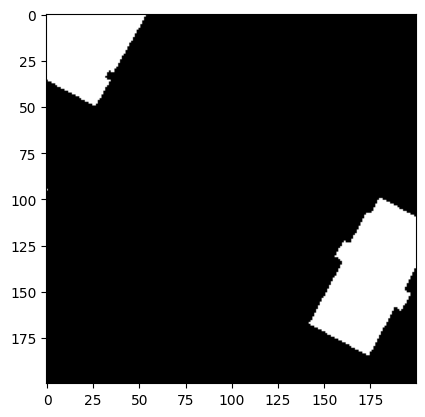

In [46]:
plt.imshow(Image.open("/Users/paulrenger/code/Paukhard/inria1358/raw_data/aerial_images_inria1358/patches/train/gt/austin1.tif__0__2.tiff"), cmap="gray")

In [56]:
save_path = '/home/konrad.horber/code/bergerbastian/inria1358/raw_data/aerial_images_inria1358/patches'

In [85]:
for i, row in enumerate(patches):
    for j, col in enumerate(row):
        im = Image.fromarray(col[0])
        im.save(f'{save_path}/chicago1_{i}_{j}.tiff')

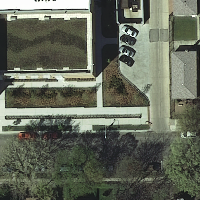

In [94]:
im = Image.open(f'{save_path}/chicago1_24_24.tiff')
im.show()

In [41]:
patches_reshape=np.reshape(patches, (25*25*1, 200, 200, 3))

In [47]:
# to reshape into scalupable file
patches_reshape_reshape = np.reshape(patches_reshape, (25,25,1,200,200,3))

# Splitting image in tensorflow RAM

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import os

2023-09-19 15:59:40.077349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
class TIFImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, batch_size, img_size):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_filenames = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_filenames) // self.batch_size

    def __getitem__(self, index):
        batch_files = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        X = []  # 3 channels for RGB
        # y = np.zeros((self.batch_size, *self.img_size, 1))  # 1 channel for grayscale
        
        first_iteration = True
        for file in batch_files:
            tensor = tf.io.read_file(f'{self.image_dir}/{file}')
            tensor = tfio.experimental.image.decode_tiff(tensor)
            tensor = tf.pad(tensor, [[60,60], [60,60], [0,0]], mode='CONSTANT', constant_values=-1)
            image_tensor = tf.expand_dims(tensor, axis=0)
            if first_iteration:
                X = image_tensor
                first_iteration = False
            else:
                X = tf.concat([X, image_tensor], axis=0)
            
            # X.append(tensor)

            # img_path = os.path.join(self.image_dir, file)
            # mask_path = os.path.join(self.mask_dir, file)  # Assuming masks have the same filenames
            
            # # Load images in RGB and masks in grayscale
            # img = Image.open(img_path).convert('RGB').resize(self.img_size)
            # mask = Image.open(mask_path).convert('L').resize(self.img_size)
            
            # X[i] = np.array(img) / 255.0  # Normalize to [0, 1]
            # y[i] = np.expand_dims(np.array(mask), axis=-1) / 255.0
        X = tf.image.extract_patches(
        X,
        sizes = [1, 256, 256, 1],
        strides = [1, 256, 256, 1],
        rates = [1, 1, 1, 1],
        padding = 'VALID'
        )
        X = tf.reshape(
            X,
            shape=(2000, 256, 256, 4)
        )
        X = X/255

        return X


    


In [21]:
BATCH_SIZE = 5
IMG_SIZE = 0
images_path = '/home/konrad.horber/code/bergerbastian/inria1358/raw_data/aerial_images_inria1358/AerialImageDataset/train/images'
ref_path = 0
train_gen = TIFImageGenerator(images_path, ref_path, BATCH_SIZE, IMG_SIZE)

In [22]:
variable = train_gen.__getitem__(0)

TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.


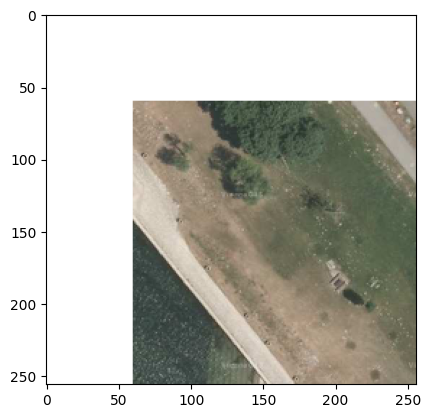

In [25]:
plt.imshow(variable[0])

In [7]:
variable = tf.convert_to_tensor(
    variable
)

In [8]:
variable = tf.image.extract_patches(
    variable,
    sizes = [1, 256, 256, 1],
    strides = [1, 256, 256, 1],
    rates = [1, 1, 1, 1],
    padding = 'VALID'
)
variable = tf.reshape(
    variable,
    shape=(2000, 256, 256, 4)
)
variable = variable/255

In [5]:
dirpath='/home/konrad.horber/code/bergerbastian/inria1358/raw_data/aerial_images_inria1358/AerialImageDataset/train/images'
tensor_batch = []
count = 0

for i in os.listdir(dirpath)
    for filename in os.listdir(dirpath):
        # if count >= 10:
        #     break
        tiff = tf.io.read_file(f'{dirpath}/{filename}')
        tensor = tfio.experimental.image.decode_tiff(tiff)
        chicago1_tensor_pad = tf.pad(tensor, [[60,60], [60,60], [0,0]], mode='CONSTANT', constant_values=-1)
        tensor_batch.append(tensor)
        count += 1


TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 4

In [6]:
tensor_batch = tf.convert_to_tensor(tensor_batch)

2023-09-19 15:14:53.003811: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18000000000 exceeds 10% of free system memory.


: 

In [4]:
tensor_batch.shape

TensorShape([10, 5000, 5000, 4])

In [ ]:
tf.conver_to_tensor_batch

In [121]:
chicago1 = tf.io.read_file('/home/konrad.horber/code/bergerbastian/inria1358/raw_data/aerial_images_inria1358/AerialImageDataset/train/images/chicago1.tif')

In [127]:
chicago1_tensor = tfio.experimental.image.decode_tiff(
    chicago1
)

In [140]:
chicago1_tensor.__sizeof__()

152

In [128]:
chicago1_tensor.shape

TensorShape([5000, 5000, 4])

In [129]:
chicago1_tensor_pad = tf.pad(chicago1_tensor, [[60,60], [60,60], [0,0]], mode='CONSTANT', constant_values=-1)

In [130]:
chicago1_tensor_pad.shape

TensorShape([5120, 5120, 4])

In [131]:
chicago1_tensor_pad_batch = tf.expand_dims(chicago1_tensor_pad, axis=0)

In [132]:
chicago1_tensor_pad_batch.shape

TensorShape([1, 5120, 5120, 4])

In [133]:
chicago1_tensor_pad_batch_extract = tf.image.extract_patches(
    chicago1_tensor_pad_batch,
    sizes = [1, 256, 256, 1],
    strides = [1, 256, 256, 1],
    rates = [1, 1, 1, 1],
    padding = 'VALID'
)

In [134]:
chicago1_tensor_pad_batch_extract.shape

TensorShape([1, 20, 20, 262144])

In [135]:
chicago1_tensor_pad_batch_extract_reshape = tf.reshape(
    chicago1_tensor_pad_batch_extract,
    shape=(400, 256, 256, 4)
)

In [136]:
chicago1_tensor_pad_batch_extract_reshape_scaled = chicago1_tensor_pad_batch_extract_reshape/255

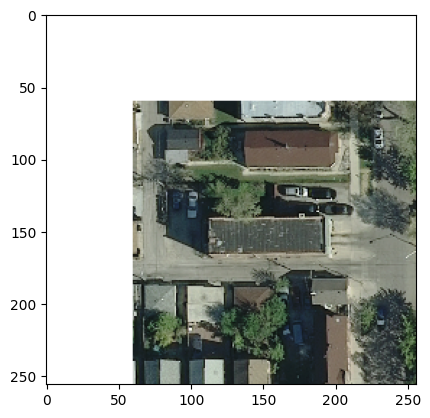

In [139]:
plt.imshow(chicago1_tensor_pad_batch_extract_reshape_scaled[0])

[#images * 20*20, 256, 256, 4]

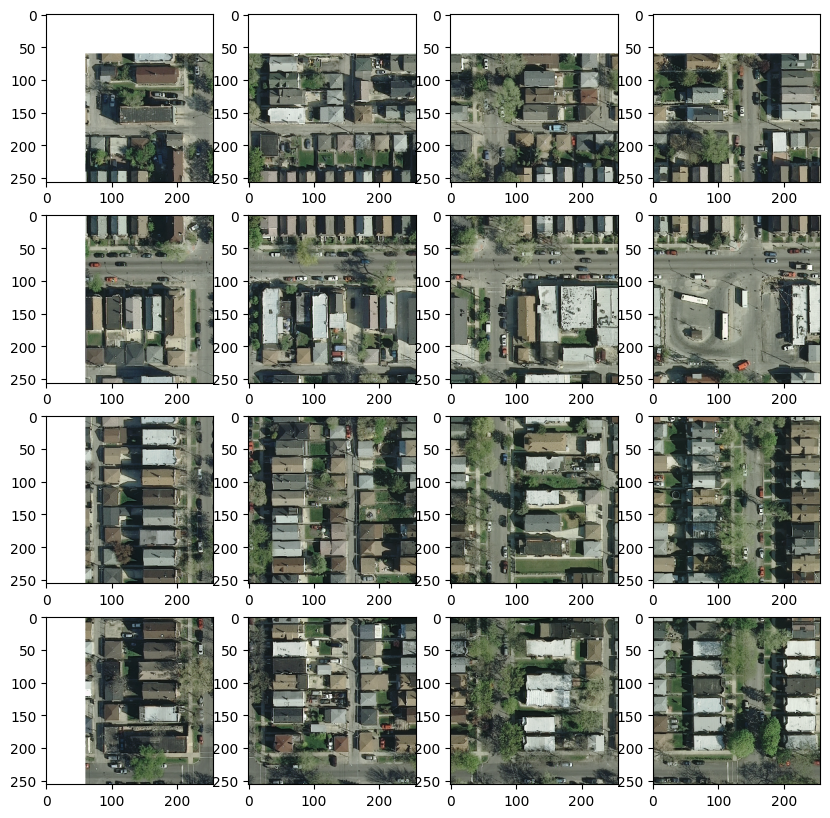

In [87]:
plt.figure(figsize=(10, 10))
for imgs in chicago1_tensor_pad_batch_extract:
    count = 0
    for r in range(4):
        for c in range(4):
            ax = plt.subplot(4, 4, count+1)
            plt.imshow(tf.reshape(imgs[r,c],shape=(256,256,4)).numpy().astype("uint8"))
            count += 1

In [30]:
chicago1_tensor_pad.shape

TensorShape([5120, 5120, 4])

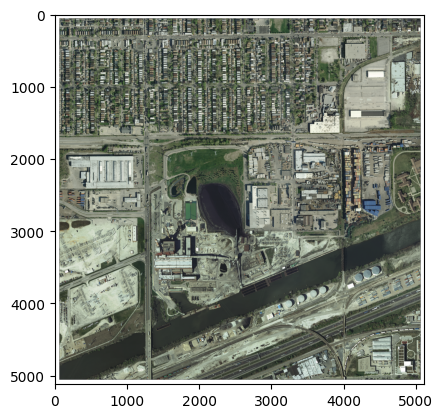

In [31]:
plt.imshow(chicago1_tensor_pad)

In [21]:
chicago1_tensor_pad = tf.keras.layers.ZeroPadding2D(
    padding=(60,60)
)

In [22]:
chicago1_tensor_pad.

AttributeError: 'ZeroPadding2D' object has no attribute 'shape'

In [ ]:
chci

In [8]:
one, two = tf.split(
    chicago1_tensor,
    num_or_size_splits=2,
    axis=0
)

In [10]:
one

TensorShape([2500, 5000, 4])

In [12]:
one_one, one_two = tf.split(
    one,
    num_or_size_splits=2,
    axis=1
)

In [13]:
one_one.shape

TensorShape([2500, 2500, 4])